# ExplainableRL: Onboarding recipe
In this notebook, a template sequence of steps to use the ExplainableRL library is described.

In [1]:
# TODO: give a bit of context and overview

### Relevant imports

In [8]:
from library import *

# Import functions
from src.foundation.engine import Engine
from src.data_handler.data_handler import DataHandler
from src.explainability.pdp import PDP
from src.explainability.shap_values import ShapValues

### 1. Parameters Setting

In [17]:
# TODO: Explain each parameter and when to use what
hyperparam_dict_ds_data_predict = {
    "dimensions": {'states': {'lead_time': 10,
                                'length_of_stay': 10,
                                'competitor_price_difference_bin': 4,
                                'demand_bin': 4},
                    'actions': {'price': 10},
                    'rewards': ['reward']
                    },

    "dataset": {'data_path': 'data/ds-data/my_example_data.parquet',
                'col_delimiter': '|',
                'n_samples': 100000,
                'normalisation': True},

    "training": {'env_type': 'strategic_pricing_predict',
                    'num_episodes': 10000,
                    'num_steps': 1,
                    'train_test_split': 0.2,
                    'evaluate': False,
                    'num_eval_steps': 10000},

    "agent": {'agent_type': 'q_learner',
                "gamma": 0.3,
                "epsilon": 0.1,
                "epsilon_decay": 0.05,
                "epsilon_minimum": 0.01,
                "learning_rate": 0.1,
                "learning_rate_decay": 0.05,
                "learning_rate_minimum": 0.01,
                "lambda": 0.2,
                "use_uncertainty": False,
                "q_importance": 0.7,
                },

    "explainability": {'shap_num_samples': 1},

    "program_flow": {"verbose": False}
}

### 2. Initialisation

In [18]:
# TODO: overview of what to initialise (DataHandler & Engine with Agent and Env inside)
# TODO: If needed by evaluation/explainability/performance add a new dictionary and explain it
hyperparam_dict = hyperparam_dict_ds_data_predict
verbose = hyperparam_dict['program_flow']['verbose']

#### 2.a. Data Loading

First of all we need to define the functions to load data from the path, and split it into training and testing.

In [19]:
# TODO: Explain data strucuture needed for both Env & how DataHanlder is built

# TODO: Load and split the data in train and test and save the test set
def load_data(data_path, n_samples, delimiter=','):
    """Load data from file.

    Args:
        delimiter (str): Which separates columns.
    """
    file_type = data_path.split('.')[-1]
    if file_type == 'csv':
        dataset = pd.read_csv(data_path, sep=delimiter)
    elif file_type == 'xlsx':
        dataset = pd.read_excel(data_path)
    elif file_type == 'parquet':
        dataset = pd.read_parquet(data_path)
    else:
        raise ValueError("File type not supported")
    dataset.sample(frac=1)
    return dataset[:n_samples]


def split_train_test(dataset, train_test_split=0.2):
    """Split dataset into train and test.

    Args:
        dataset (pd.DataFrame): Dataset.
        train_test_split (float): Proportion of test data.
    
    Returns:
        train_dataset (pd.DataFrame): Train dataset.
        test_dataset (pd.DataFrame): Test dataset.
    """
    dataset = dataset.sample(frac=1)
    split = int(train_test_split*len(dataset))
    return dataset[split:], dataset[:split]

Load dataset and split it:

In [20]:
dataset = load_data(hyperparam_dict['dataset']['data_path'], hyperparam_dict['dataset']['n_samples'])
train_dataset, test_dataset = split_train_test(dataset)

Initialize Datahandler:

In [21]:
# TODO: Add explanation
if verbose:
    timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print(f"{timestamp}: Load data")
dh = DataHandler(hyperparam_dict=hyperparam_dict, dataset=train_dataset, test_dataset=test_dataset)

Prepare data for engine:

In [22]:
dh.prepare_data_for_engine(col_delimiter=hyperparam_dict['dataset']['col_delimiter'])


#### 2.b. Engine Initialisation

In [23]:
# TODO: Add explanation
if verbose:
    timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print(f"{timestamp}: Initialise Engine")
engine = Engine(dh=dh, hyperparam_dict=hyperparam_dict)


#### 2.c. Environment and Agent Initialisation

In [24]:
if verbose:
    timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print(f"{timestamp}: Create the world")
engine.create_world()

### 3. Agent Training and Saving

In [11]:
# TODO: Add explanation

#### 3.a. Training

In [25]:
# TODO: Add explanation
if verbose:
    timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    n_samples = hyperparam_dict['n_samples']
    n_episodes = hyperparam_dict['n_episodes']
    print(f"{timestamp}: Train the agent on {n_samples} samples and {n_episodes} episodes")
engine.train_agent()

100%|██████████| 10000/10000 [02:04<00:00, 80.12it/s]


#### 3.b. Saving

In [26]:
# TODO: Add explanation
# TODO: Add saving and uploading process in pickle
# TODO: Take path and file name from dictionary
import pickle

with open('runs/engine_test.pkl','wb') as f:
    pickle.dump(engine, f)


### 4. Agent Evaluation

Import Evaluator class. The Evaluator class provides custom Reinforcement Learning Plots (such as cumulative reward per episode, or average reward distribution) averaged across different runs. It also provides other metrics such as: total agent reward versus historical reward on the test set, or action accuracy versus historical data.

In [27]:
from src.evaluation.evaluator import Evaluator

evaluator = Evaluator(engine_path = ['runs/engine_test.pkl'])

Evaluate cumulative reward on test set using historical vs learnt agent policy:

In [30]:
print(f"Historical baseline: {evaluator.hist_cum_rewards()}")
print(f"Agent Policy: {np.sum(evaluator.agent_cum_rewards())}")

Historical baseline: 146992.99015972763
Agent Policy: 229378.54060825467


Plot cumulative reward versus training episode:

KeyError: 'y'

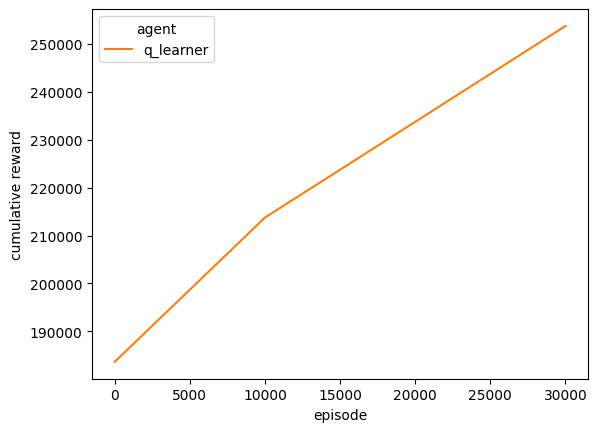

In [13]:
evaluator.plot_training_curve()

Plot average reward distribution:

In [16]:
import numpy as np
print(np.sum([r[0] for r in evaluator.eval_results[0]['rewards_agent']]))

print(np.sum([r[0] for r in evaluator.eval_results[0]['rewards_hist']]))

183813.84296313708
144038.3227933938


saving figure


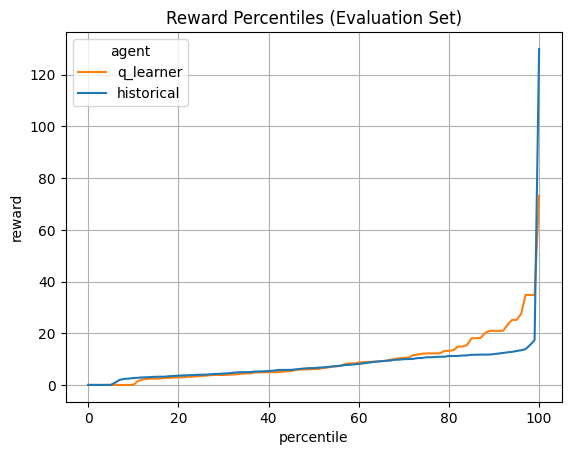

In [17]:
evaluator.plot_reward_distribution()

### 5. Explainability

In [ ]:
# TODO: Add explanation on explainability framework

#### 5.a. PDP Plots

In [ ]:

# TODO: Add explanation
if verbose:
    timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print(f"{timestamp}: Show PDPs plots")
pdp = PDP(engine=engine)
pdp.build_data_for_plots(engine.agent.Q, engine.agent.Q_num_samples)
type_features = hyperparam_dict['feature_types']
fig_name = "PDP plots - All states"
pdp.plot_pdp(states_names=state_labels, 
             fig_name=fig_name,
             type_features=type_features, 
             savefig=True, 
             all_states=True)
# TODO: Change PDP parameters based on new parameters dictionary

#### 5.b. Shap Values

In [ ]:
# TODO: Add explanation
if verbose:
    timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print(f"{timestamp}: Show SHAP values plots")
shap_values = ShapValues(sample=[8, 1, 1, 1],
                         engine=engine,
                         number_of_samples=shap_num_samples)
shaps, predicted_action = shap_values.compute_shap_values()
print(shaps)
print(predicted_action)
# TODO: Change SHAP parameters based on new parameters dictionary

### 6. Performance

In [ ]:
# TODO: Add explanation
# Explain how to run the performance and what all the results mean

### 7. Documentation

In [ ]:
# TODO: Add explanation
# Explain how to access documentation in the browser